In [7]:
# Otimizar sklearn
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


---


# Baixar dataset

In [8]:
# !pip install kaggle wordcloud nltk
# !echo '{"username":"pauloubirajara","key":"4a5d061c2eade0bf96665e1fb7a8fd28"}' > /root/.kaggle/kaggle.json
# !sleep 3
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d brobear1995/rss-feed-topic-classifier --force
# !unzip -o -u rss-feed-topic-classifier.zip

---


# Imports

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import re

from nltk import download
from nltk.tokenize import word_tokenize

# Filtrar stopwords
from nltk.corpus import stopwords
from string import punctuation
download('stopwords')
download('punkt')

STOPWORDS = stopwords.words('english')
STOPWORDS.extend(punctuation)
# STOPWORDS.extend(['\\'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# Obter uma representação vetorial a partir de um texto
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score, cross_val_predict

# Balancear dados
from imblearn.over_sampling import SMOTE

---


# Carregar dados

In [11]:
df_dados = pd\
  .read_csv('topic_classifier.csv')\
  .astype('str')\
  .sample(frac=1)
print(df_dados['Topic'].value_counts())
df_dados

Entertainment           2028
News                    1106
Sprituality              678
Machine Learning         663
Software Development     580
Independence             392
Science                  318
Wellness                 106
Name: Topic, dtype: int64


,title,c1body,Topic
2767,This is what YouTube’s all about!,This is what YouTube’s all about! nitter.net/M...,Science
43,Ep. 168 – The Domain of Spirit,Ram Dass explores how spiritual practice helps...,Sprituality
4598,Views on software jobs in the city?,I am a 3rd year computer science engineering s...,News
4257,RT by @davidfrawleyved: Though Rigveda is the ...,"Though Rigveda is the oldest, largest and most...",Sprituality
1047,Teaching myself an upper level pure math cours...,Get 25% off a year subscription to CuriositySt...,Machine Learning
...,...,...,...
2694,RT by @knappily: @knappily is an interesting f...,@knappily is an interesting find. Gives all ne...,News
2063,Heavenly Underrated Cover,[link] [comments],Entertainment
1885,Nearly half of adult Canadians struggle with l...,Comments,News
1042,Why The Speed Of Light* Can't Be Measured,"Physics students learn the speed of light, c, ...",Science


In [12]:
entertainment = df_dados[df_dados['Topic'] == 'Entertainment'].sample(frac=1).iloc[:678]
news = df_dados[df_dados['Topic'] == 'News'].sample(frac=1).iloc[:678]
df_dados_2 = df_dados[df_dados['Topic'] != 'Entertainment']
df_dados_2 = df_dados_2[df_dados_2['Topic'] != 'News']
df_dados_2 = pd.concat([df_dados_2, news, entertainment])
y_true = df_dados['Topic']
X = df_dados.drop(columns=['Topic'])

---


In [13]:
def TFIDF(corpus, as_frame=True):
  vectorizer = TfidfVectorizer(
    stop_words=STOPWORDS,
    lowercase=True,
    # max_features=10000,
  )
  # Colunas variam até 36351 features se não limitadas
  tfidf = vectorizer.fit_transform(corpus)
  
  if as_frame:
    try:
      df_tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf, columns=vectorizer.get_feature_names_out())
    except:
      df_tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf, columns=vectorizer.get_feature_names())
    return df_tfidf
  
  return tfidf

In [14]:
def BAG_OF_WORDS(corpus, as_frame=True):
  count_vectorizer = CountVectorizer(
    lowercase=True, 
    # max_features=10000,
    stop_words=STOPWORDS
  )
  bow = count_vectorizer.fit_transform(corpus)
  
  if as_frame:
    try:
      df_bow = pd.DataFrame.sparse.from_spmatrix(bow, columns=count_vectorizer.get_feature_names_out())
    except:
      df_bow = pd.DataFrame.sparse.from_spmatrix(bow, columns=count_vectorizer.get_feature_names())
    
    return df_bow
  
  return bow

In [74]:
sm = SMOTE(n_jobs=-1)

def get_smote_as_dataframe(
  features: pd.SparseDtype,
  target: pd.Series,
  representation_method
) -> (pd.SparseDtype):
  smote = sm.fit_resample(
    representation_method(features, as_frame=False),
    pd.DataFrame(target),
  )

  smote_features, smote_target = smote
  return smote_features, smote_target

In [16]:
def show_report(y_true, y_pred, labels):
	print(classification_report(y_true, y_pred, target_names=labels))

In [35]:
def logistic_regression():
  return LogisticRegression()
  
def random_forest():
  return RandomForestClassifier()

def decision_tree():
  return DecisionTreeClassifier()
  # return DecisionTreeClassifier(max_depth=5)

---


In [13]:
# !lscpu | grep "CPU(s)"

In [31]:
features = TFIDF(X['title'] + X['c1body'])
topics = sorted(y_true.unique())

---


# Logistic Regression + TFIDF (Sem smote)

In [ ]:
scores = cross_val_score(logistic_regression(), features, y_true, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(logistic_regression(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(logistic_regression(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

In [ ]:
y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Regressão Logística - TFIDF')
plt.show()

---


# Random Forest + TFIDF (Sem smote)

In [25]:
scores = cross_val_score(random_forest(), features.values, y_true, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(random_forest(), features.values, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

0.8557368262466827
                      precision    recall  f1-score   support

       Entertainment       0.79      0.95      0.86      2028
        Independence       0.87      0.72      0.79       392
    Machine Learning       0.90      0.80      0.85       663
                News       0.85      0.84      0.85      1106
             Science       0.91      0.39      0.55       318
Software Development       0.95      0.94      0.94       580
         Sprituality       0.94      0.87      0.90       678
            Wellness       1.00      0.74      0.85       106

            accuracy                           0.85      5871
           macro avg       0.90      0.78      0.82      5871
        weighted avg       0.86      0.85      0.85      5871



In [29]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(random_forest(), features.values, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(random_forest(), features.values, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

Entertainment x Não Entertainment
0.901041268296075
                   precision    recall  f1-score   support

    Entertainment       0.87      0.84      0.85      2028
Não Entertainment       0.92      0.93      0.92      3843

         accuracy                           0.90      5871
        macro avg       0.89      0.89      0.89      5871
     weighted avg       0.90      0.90      0.90      5871


Independence x Não Independence
0.95571625583794
                  precision    recall  f1-score   support

    Independence       0.98      0.33      0.50       392
Não Independence       0.95      1.00      0.98      5479

        accuracy                           0.96      5871
       macro avg       0.97      0.67      0.74      5871
    weighted avg       0.96      0.96      0.94      5871


Machine Learning x Não Machine Learning
0.9552040236878396
                      precision    recall  f1-score   support

    Machine Learning       0.99      0.61      0.76       663
Não M

[[1935    7    6   65    2    2   11    0]
 [  81  281   13    7    3    4    3    0]
 [  56   26  530   31    3    8    9    0]
 [ 151    2    7  932    1    9    4    0]
 [ 144    7   20   13  124    3    7    0]
 [  11    0    9   13    2  543    2    0]
 [  71    0    1   14    2    1  589    0]
 [   2    0    1   20    0    1    4   78]]


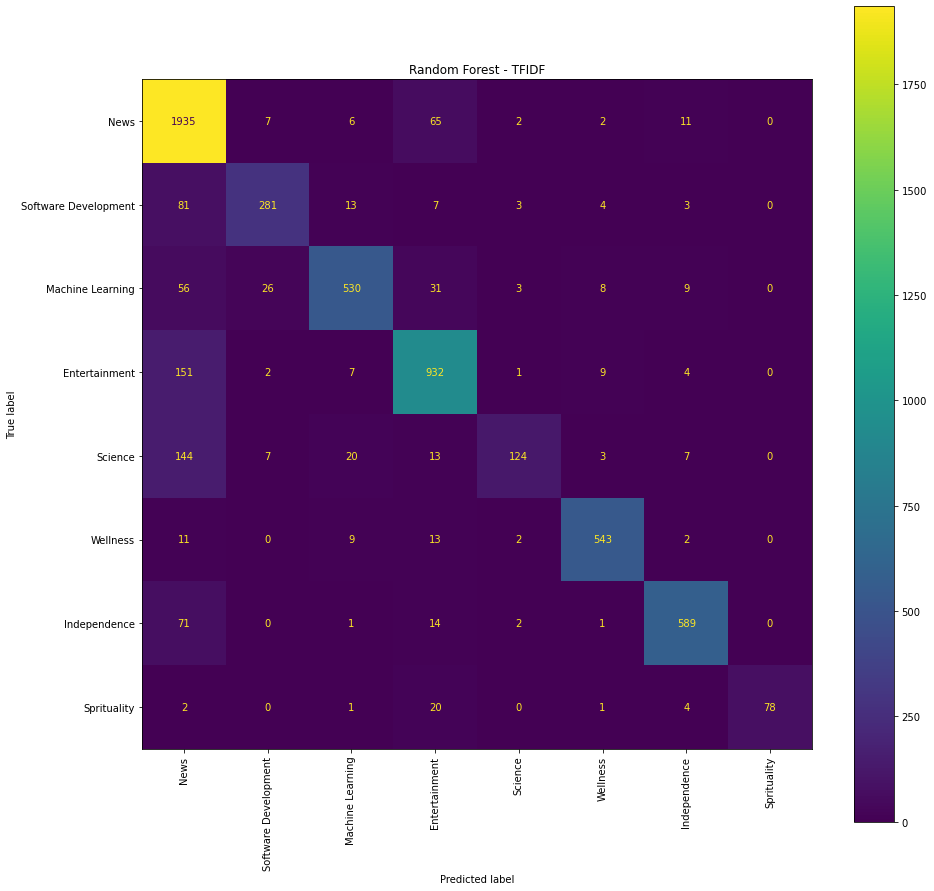

In [26]:
# y_pred = cross_val_predict(random_forest(), features.values, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Random Forest - TFIDF')
plt.show()

---


# Decision Tree + TFIDF (Sem smote)

In [33]:
scores = cross_val_score(decision_tree(), features, y_true, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(decision_tree(), features, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

0.5821866054769438
                      precision    recall  f1-score   support

       Entertainment       0.70      0.85      0.77      2028
        Independence       0.85      0.14      0.24       392
    Machine Learning       0.65      0.42      0.51       663
                News       0.35      0.76      0.48      1106
             Science       0.60      0.01      0.02       318
Software Development       0.97      0.46      0.62       580
         Sprituality       0.99      0.35      0.52       678
            Wellness       1.00      0.15      0.26       106

            accuracy                           0.58      5871
           macro avg       0.76      0.39      0.43      5871
        weighted avg       0.70      0.58      0.56      5871



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(decision_tree(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(decision_tree(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[1719    5    6  295    0    1    2    0]
 [ 146   56   70  118    2    0    0    0]
 [  91    1  279  287    0    4    1    0]
 [ 256    1    7  839    0    3    0    0]
 [ 149    3   19  144    3    0    0    0]
 [   2    0   37  274    0  267    0    0]
 [  76    0    5  359    0    0  238    0]
 [   1    0    9   80    0    0    0   16]]


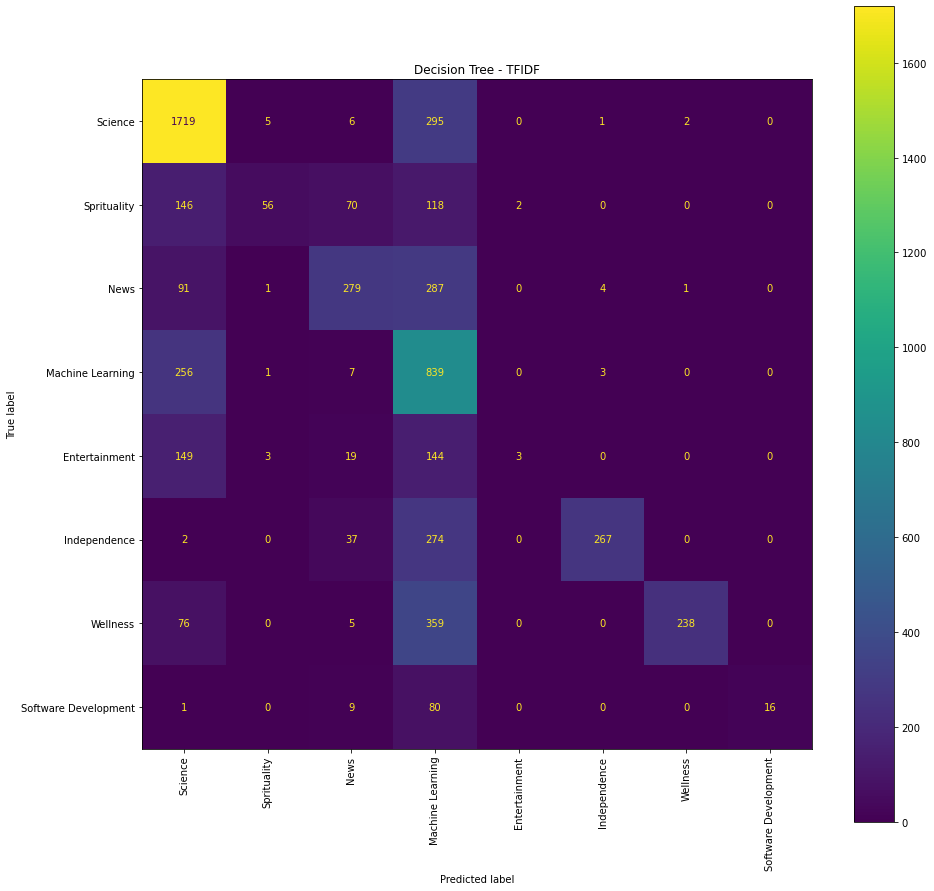

In [34]:
# y_pred = cross_val_predict(decision_tree(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Decision Tree - TFIDF')
plt.show()

---
# Logistic Regression + BOW (Sem smote)

In [36]:
features = BAG_OF_WORDS(X['title'] + X['c1body'])
topics = sorted(y_true.unique())

In [22]:
# scores = cross_val_score(logistic_regression(), features, y_true, cv=10, n_jobs=6)
# print(scores.mean())
# y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

                      precision    recall  f1-score   support

       Entertainment       0.80      0.93      0.86      2028
        Independence       0.81      0.71      0.76       392
    Machine Learning       0.89      0.81      0.85       663
                News       0.82      0.84      0.83      1106
             Science       0.75      0.47      0.58       318
Software Development       0.95      0.91      0.93       580
         Sprituality       0.93      0.82      0.87       678
            Wellness       0.98      0.75      0.85       106

            accuracy                           0.84      5871
           macro avg       0.87      0.78      0.82      5871
        weighted avg       0.84      0.84      0.84      5871



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(logistic_regression(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(logistic_regression(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[1892   16    9   65   22    3   21    0]
 [  70  280   16   14    5    3    3    1]
 [  44   23  537   38   10    8    3    0]
 [ 143   13   12  925    3    7    3    0]
 [ 126    5    7   19  149    4    8    0]
 [   8    5   16   20    4  526    1    0]
 [  75    3    8   32    4    0  555    1]
 [   2    0    1   14    1    2    6   80]]


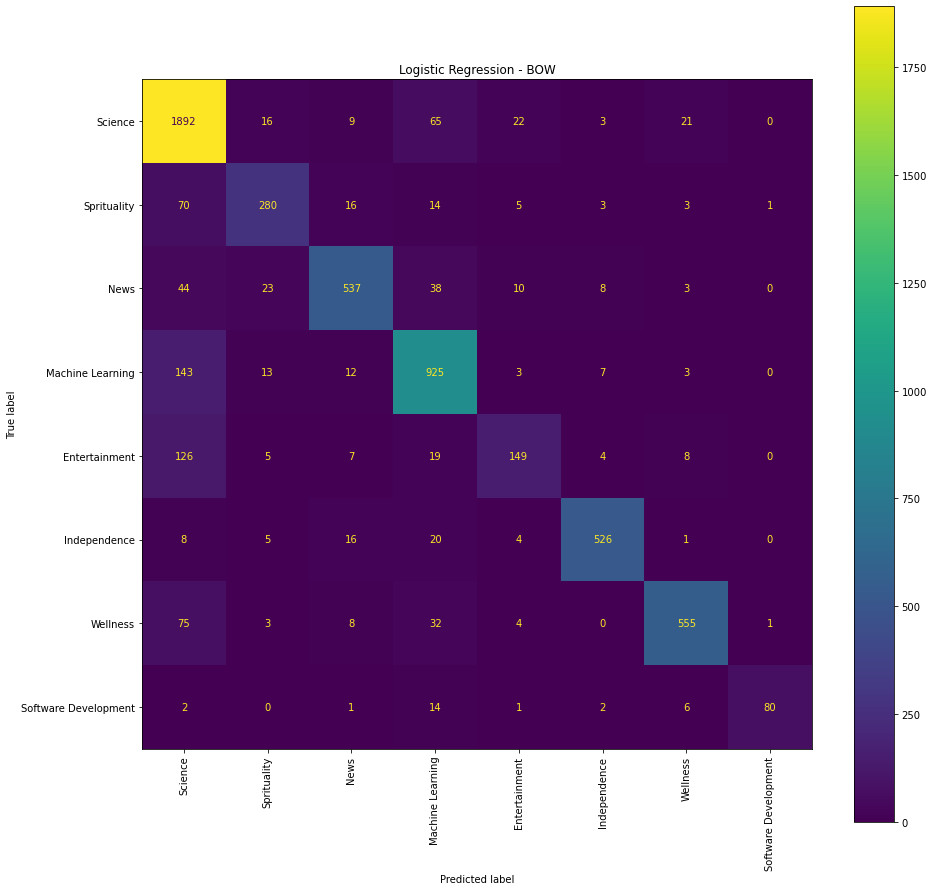

In [23]:
# y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Logistic Regression - BOW')
plt.show()

---


# Random Forest + BOW (Sem smote)

In [28]:
# scores = cross_val_score(random_forest(), features.values, y_true, cv=10, n_jobs=6)
# print(scores.mean())
# y_pred = cross_val_predict(random_forest(), features.values, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

                      precision    recall  f1-score   support

       Entertainment       0.82      0.88      0.85      2028
        Independence       0.74      0.72      0.73       392
    Machine Learning       0.78      0.71      0.74       663
                News       0.81      0.82      0.81      1106
             Science       0.55      0.47      0.51       318
Software Development       0.88      0.83      0.85       580
         Sprituality       0.88      0.84      0.86       678
            Wellness       0.76      0.73      0.74       106

            accuracy                           0.80      5871
           macro avg       0.78      0.75      0.76      5871
        weighted avg       0.80      0.80      0.80      5871



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(random_forest(), features.values, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(random_forest(), features.values, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[1933    6    8   72    0    2    7    0]
 [  74  289   12    7    2    4    4    0]
 [  55   29  526   34    4    7    8    0]
 [ 152    3    6  935    1    4    5    0]
 [ 139    8   28   14  120    4    5    0]
 [   8    0   12   17    0  541    2    0]
 [  65    0    1   16    2    0  594    0]
 [   1    0    1   20    0    1    4   79]]


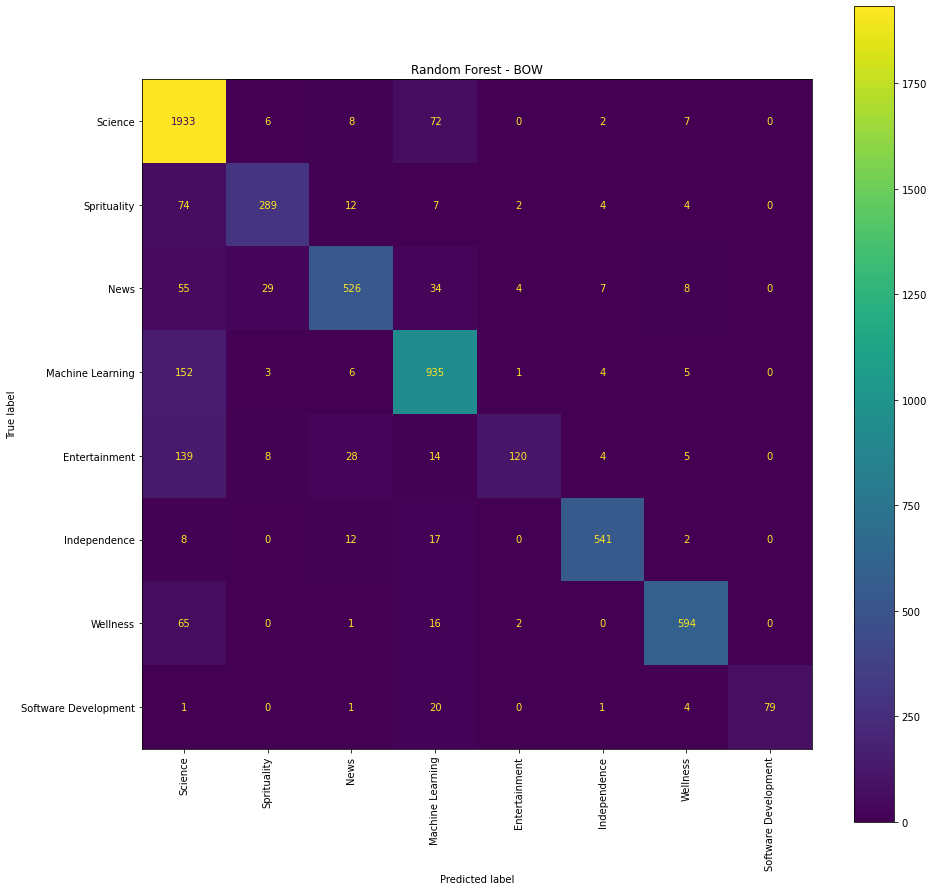

In [25]:
# y_pred = cross_val_predict(random_forest(), features.values, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Random Forest - BOW')
plt.show()

---


# Decision Tree + BOW (Sem smote)

In [37]:
scores = cross_val_score(decision_tree(), features, y_true, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(decision_tree(), features, y_true, cv=10, n_jobs=6)
show_report(y_true, y_pred, topics)

0.8025854975721123
                      precision    recall  f1-score   support

       Entertainment       0.82      0.88      0.85      2028
        Independence       0.73      0.72      0.73       392
    Machine Learning       0.78      0.73      0.75       663
                News       0.80      0.81      0.81      1106
             Science       0.52      0.43      0.47       318
Software Development       0.88      0.84      0.86       580
         Sprituality       0.87      0.84      0.85       678
            Wellness       0.77      0.71      0.74       106

            accuracy                           0.80      5871
           macro avg       0.77      0.75      0.76      5871
        weighted avg       0.80      0.80      0.80      5871



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(decision_tree(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(decision_tree(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[1790   27   28  106   47   10   19    1]
 [  52  281   23   12   17    4    2    1]
 [  48   41  472   36   24   24   14    4]
 [ 131    7   18  905   15   12   14    4]
 [ 103   16   14   18  149    6    9    3]
 [  16    6   37   14    8  479   14    6]
 [  46    3   16   22    7    7  572    5]
 [   2    0    1   10    5    4    7   77]]


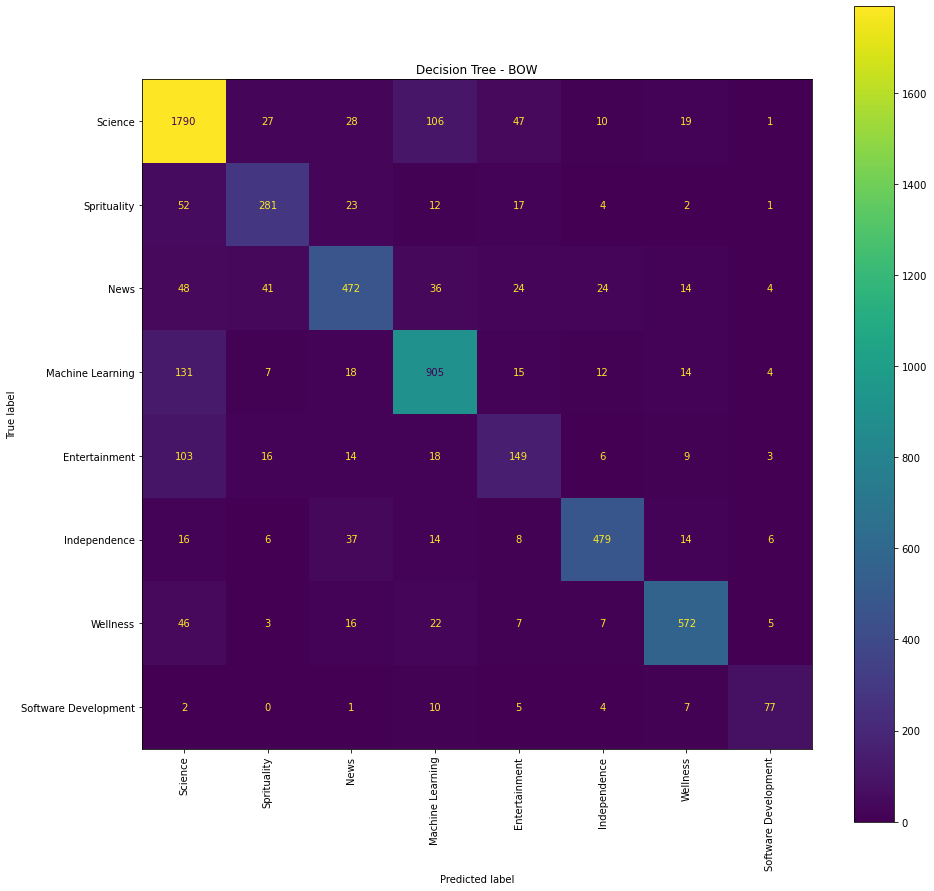

In [27]:
# y_pred = cross_val_predict(decision_tree(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(y_true, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=y_true.unique()
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Decision Tree - BOW')
plt.show()

---
# Logistic Regression + TFIDF (Com SMOTE)

In [86]:
y_true = df_dados_2['Topic']
X = df_dados_2.drop(columns=['Topic'])

features, target = get_smote_as_dataframe(
	features=X['title'] + X['c1body'],
	target=y_true,
	representation_method=TFIDF
)
topics = sorted(y_true.unique())
target.value_counts()

Topic               
Entertainment           678
Independence            678
Machine Learning        678
News                    678
Science                 678
Software Development    678
Sprituality             678
Wellness                678
dtype: int64

In [87]:
scores = cross_val_score(logistic_regression(), features, target, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(logistic_regression(), features, target, cv=10, n_jobs=6)
show_report(target, y_pred, topics)

0.8159925383784223
                      precision    recall  f1-score   support

       Entertainment       0.63      0.83      0.72       678
        Independence       0.83      0.83      0.83       678
    Machine Learning       0.91      0.79      0.84       678
                News       0.86      0.68      0.76       678
             Science       0.74      0.67      0.71       678
Software Development       0.95      0.90      0.92       678
         Sprituality       0.93      0.83      0.88       678
            Wellness       0.78      0.99      0.87       678

            accuracy                           0.82      5424
           macro avg       0.83      0.82      0.82      5424
        weighted avg       0.83      0.82      0.82      5424



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(logistic_regression(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(logistic_regression(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[566  20   6  14  46   6  14   6]
 [ 79 565   5   5  13   1   3   7]
 [ 26  42 534  18  27  14   4  13]
 [ 63  21   8 460  42   9   6  69]
 [105  22  10   8 457   3   9  64]
 [  3   4  18  12  11 609   3  18]
 [ 50   7   7  20  20   2 565   7]
 [  1   0   1   1   1   0   4 670]]


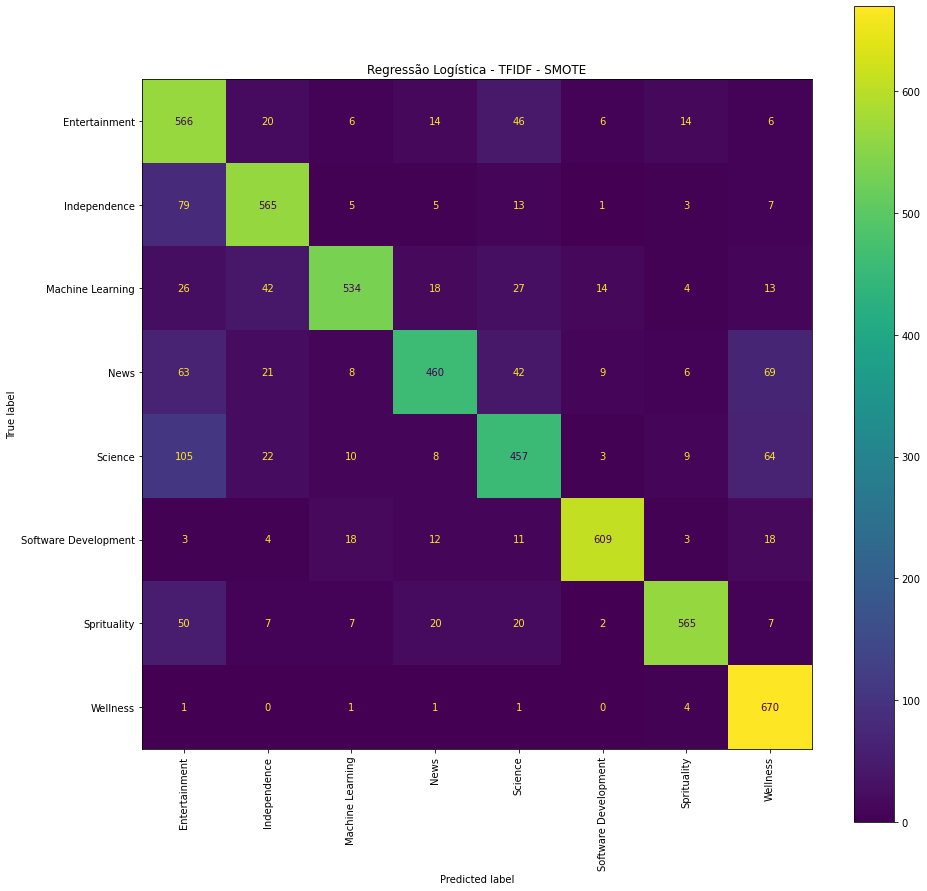

In [88]:
# y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(target, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=topics
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Regressão Logística - TFIDF - SMOTE')
plt.show()

---
# Random Forest + TFIDF (Com SMOTE)

In [89]:
scores = cross_val_score(random_forest(), features, target, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(random_forest(), features, target, cv=10, n_jobs=6)
show_report(target, y_pred, topics)

0.7938723641380061
                      precision    recall  f1-score   support

       Entertainment       0.75      0.64      0.69       678
        Independence       0.77      0.85      0.81       678
    Machine Learning       0.92      0.78      0.84       678
                News       0.94      0.60      0.73       678
             Science       0.54      0.77      0.64       678
Software Development       0.88      0.92      0.90       678
         Sprituality       0.98      0.87      0.92       678
            Wellness       0.77      0.93      0.84       678

            accuracy                           0.79      5424
           macro avg       0.82      0.79      0.80      5424
        weighted avg       0.82      0.79      0.80      5424



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(random_forest(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(random_forest(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[433  35   8  10 162  17   6   7]
 [ 12 573   6   2  69   6   3   7]
 [ 16  62 527   5  31  23   2  12]
 [ 47  22  14 405 106  16   2  66]
 [ 30  38   8   0 523  13   1  65]
 [  2   3  10   7  10 622   1  23]
 [ 41   8   1   3  18  13 588   6]
 [  0   1   0   0  45   0   0 632]]


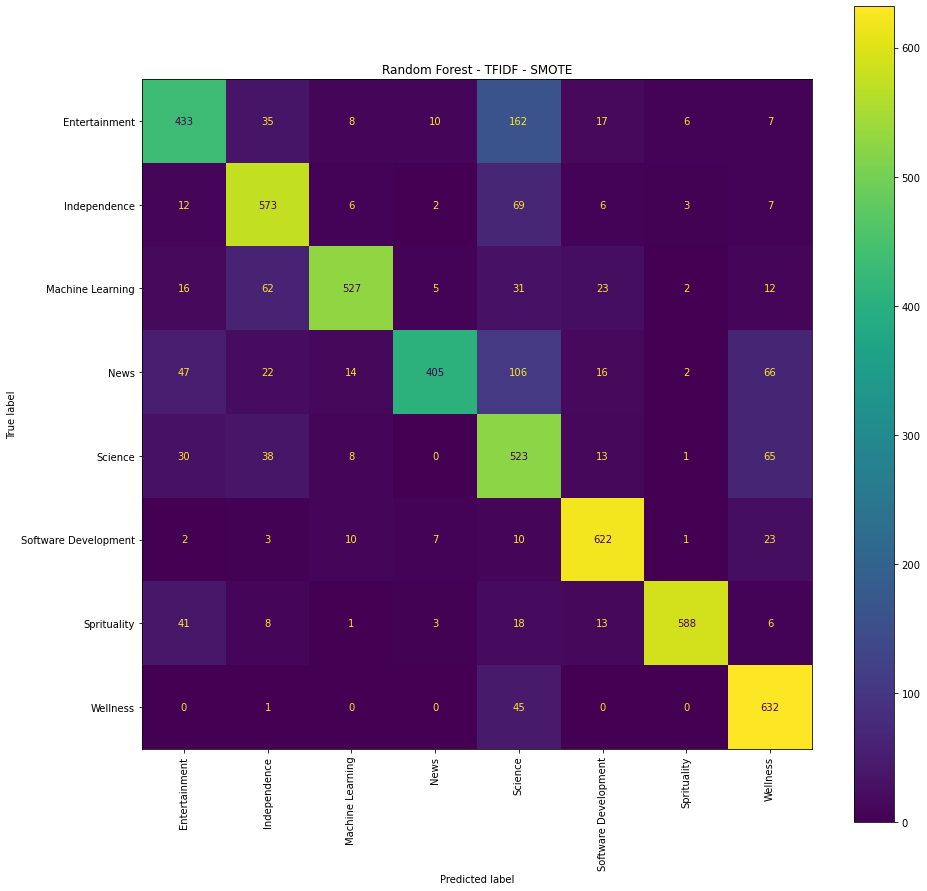

In [90]:
# y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(target, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=topics
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Random Forest - TFIDF - SMOTE')
plt.show()

---
# Decision Tree + TFIDF (Com SMOTE)

In [91]:
scores = cross_val_score(decision_tree(), features, target, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(decision_tree(), features, target, cv=10, n_jobs=6)
show_report(target, y_pred, topics)

0.740416097531141
                      precision    recall  f1-score   support

       Entertainment       0.73      0.58      0.64       678
        Independence       0.81      0.77      0.79       678
    Machine Learning       0.78      0.72      0.75       678
                News       0.83      0.59      0.69       678
             Science       0.49      0.69      0.57       678
Software Development       0.84      0.85      0.84       678
         Sprituality       0.87      0.84      0.85       678
            Wellness       0.73      0.91      0.81       678

            accuracy                           0.74      5424
           macro avg       0.76      0.74      0.74      5424
        weighted avg       0.76      0.74      0.74      5424



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(decision_tree(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(decision_tree(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[390  29  17  22 174  19  20   7]
 [ 25 523  22   8  76   4   7  13]
 [ 17  44 486  18  43  35  16  19]
 [ 27  13  19 403 110  20  11  75]
 [ 42  27  28  13 465  13  16  74]
 [  5   4  34   9  16 575  12  23]
 [ 30   7  14  13  18  14 567  15]
 [  0   0   1   1  49   4   4 619]]


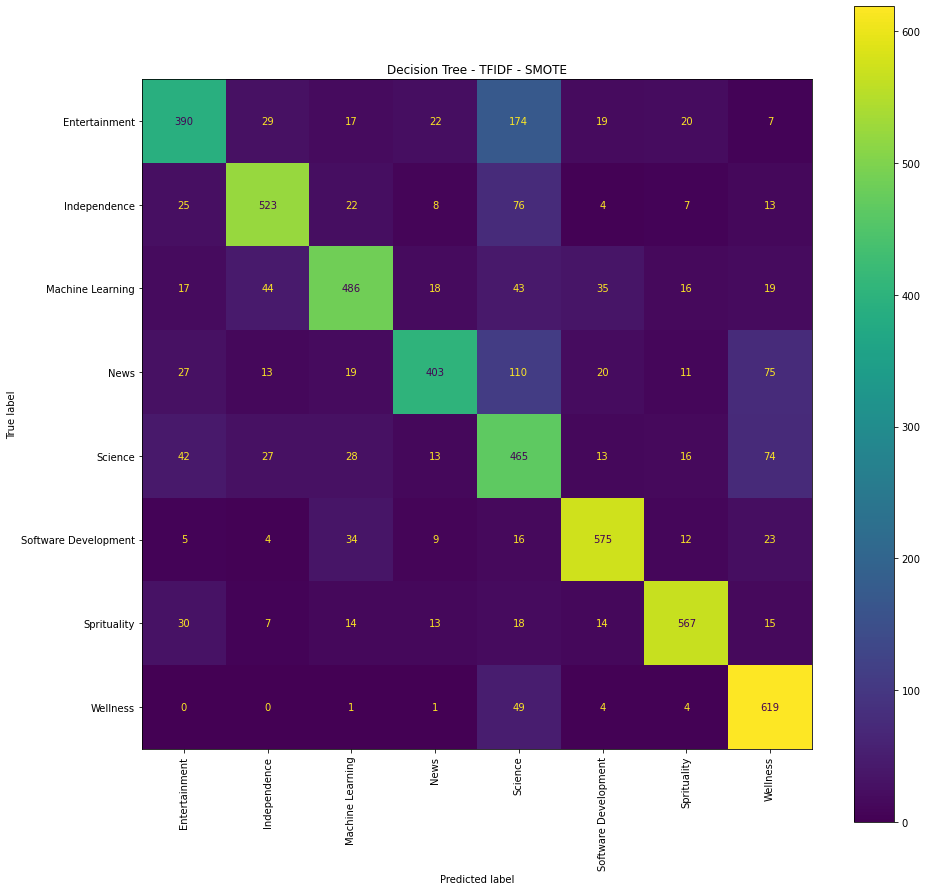

In [92]:
# y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(target, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=topics
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Decision Tree - TFIDF - SMOTE')
plt.show()

---
# Logistic Regression + BOW (Com SMOTE)

In [93]:
y_true = df_dados_2['Topic']
X = df_dados_2.drop(columns=['Topic'])

features, target = get_smote_as_dataframe(
	features=X['title'] + X['c1body'],
	target=y_true,
	representation_method=BAG_OF_WORDS
)
topics = sorted(y_true.unique())
target.value_counts()

Topic               
Entertainment           678
Independence            678
Machine Learning        678
News                    678
Science                 678
Software Development    678
Sprituality             678
Wellness                678
dtype: int64

In [94]:
scores = cross_val_score(logistic_regression(), features, target, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(logistic_regression(), features, target, cv=10, n_jobs=6)
show_report(target, y_pred, topics)

0.8080684729499229
                      precision    recall  f1-score   support

       Entertainment       0.61      0.82      0.70       678
        Independence       0.83      0.82      0.83       678
    Machine Learning       0.91      0.79      0.84       678
                News       0.84      0.66      0.74       678
             Science       0.75      0.65      0.70       678
Software Development       0.94      0.90      0.92       678
         Sprituality       0.92      0.83      0.88       678
            Wellness       0.76      0.99      0.86       678

            accuracy                           0.81      5424
           macro avg       0.82      0.81      0.81      5424
        weighted avg       0.82      0.81      0.81      5424



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(logistic_regression(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(logistic_regression(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[556  15   7  14  55   6  15  10]
 [ 79 558   5   9  18   2   2   5]
 [ 25  40 534  17  26  17   6  13]
 [ 68  23   7 446  22  10   6  96]
 [119  24   9  10 443   3  10  60]
 [  5   3  18  11   5 611   3  22]
 [ 52   6   7  21  19   0 564   9]
 [  1   0   1   0   1   0   4 671]]


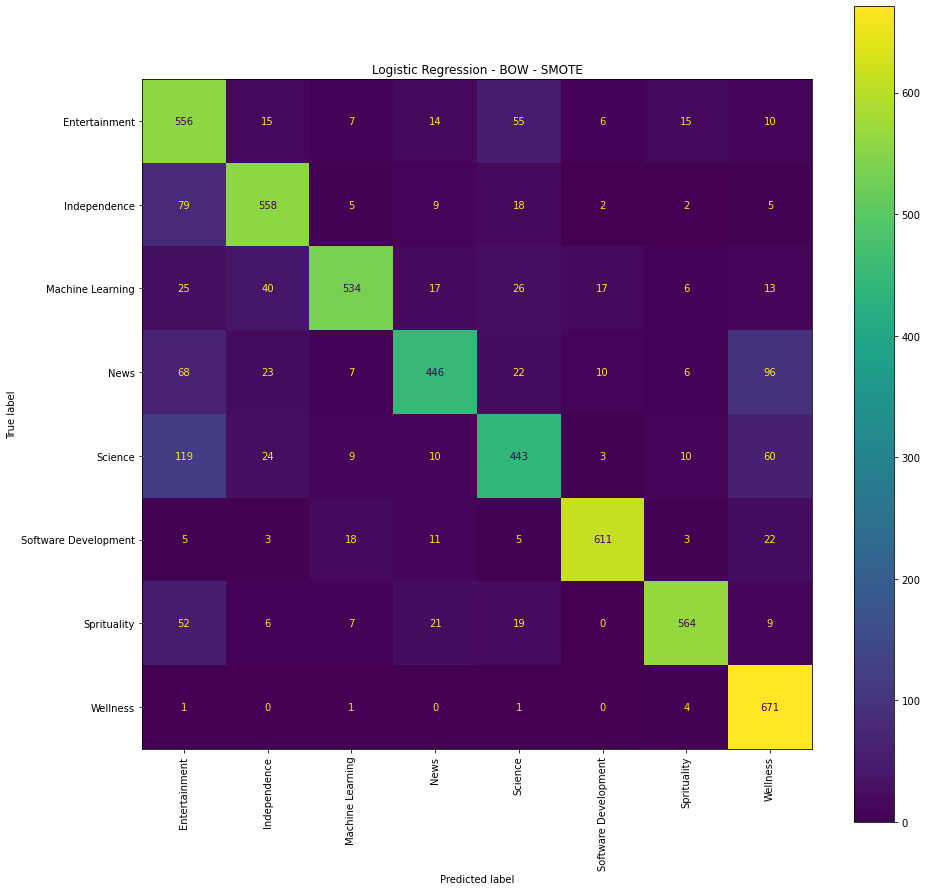

In [95]:
# y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(target, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=topics
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Logistic Regression - BOW - SMOTE')
plt.show()

---
# Random Forest + BOW (Com SMOTE)

In [96]:
scores = cross_val_score(random_forest(), features, target, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(random_forest(), features, target, cv=10, n_jobs=6)
show_report(target, y_pred, topics)

0.7947928346686782
                      precision    recall  f1-score   support

       Entertainment       0.71      0.65      0.68       678
        Independence       0.76      0.84      0.80       678
    Machine Learning       0.92      0.77      0.84       678
                News       0.93      0.55      0.69       678
             Science       0.61      0.77      0.68       678
Software Development       0.94      0.91      0.93       678
         Sprituality       0.97      0.88      0.92       678
            Wellness       0.71      1.00      0.83       678

            accuracy                           0.80      5424
           macro avg       0.82      0.80      0.79      5424
        weighted avg       0.82      0.80      0.79      5424



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(random_forest(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(random_forest(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[440  38   9   5 161   4   8  13]
 [ 17 572   6   1  71   3   1   7]
 [ 24  61 524   8  30  11   3  17]
 [ 51  49   8 370  43  18   5 134]
 [ 40  25   9   2 521   2   2  77]
 [  7   1  12   8   9 619   1  21]
 [ 41   5   2   4  23   1 594   8]
 [  0   0   0   1   0   0   0 677]]


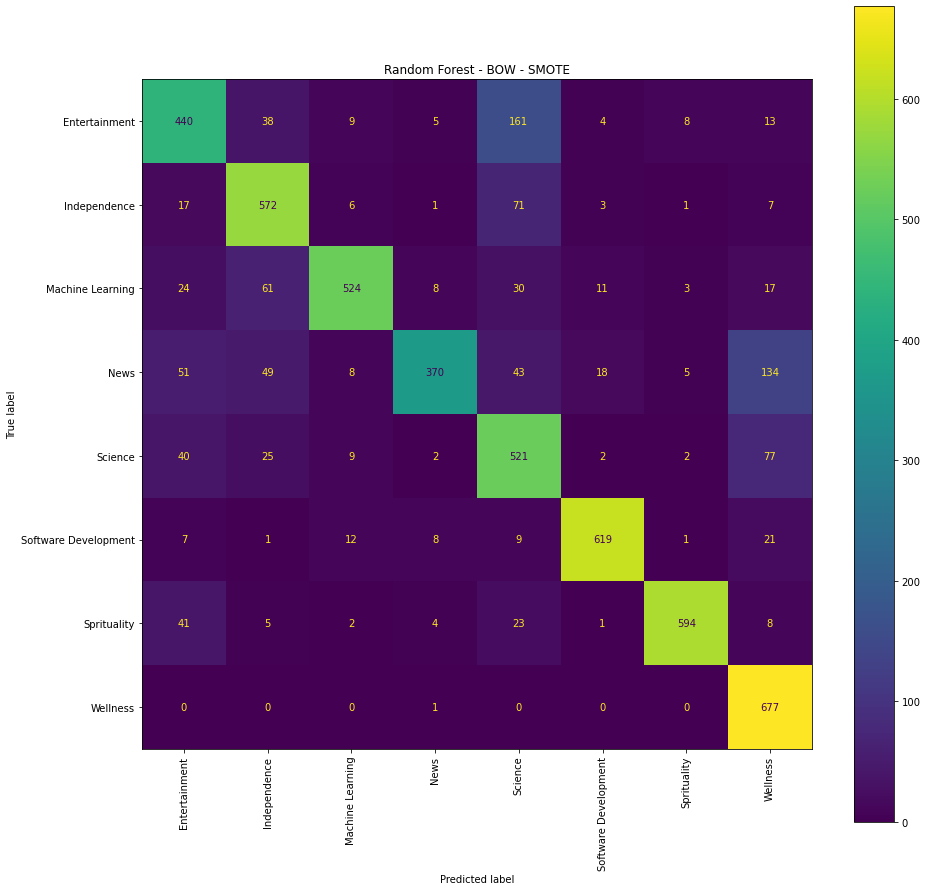

In [97]:
# y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(target, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=topics
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Random Forest - BOW - SMOTE')
plt.show()

---
# Decision Tree + BOW (Com SMOTE)

In [98]:
scores = cross_val_score(decision_tree(), features, target, cv=10, n_jobs=6)
print(scores.mean())
y_pred = cross_val_predict(decision_tree(), features, target, cv=10, n_jobs=6)
show_report(target, y_pred, topics)

0.7518426399733611
                      precision    recall  f1-score   support

       Entertainment       0.71      0.59      0.65       678
        Independence       0.77      0.78      0.78       678
    Machine Learning       0.79      0.70      0.74       678
                News       0.82      0.56      0.66       678
             Science       0.55      0.69      0.61       678
Software Development       0.89      0.86      0.87       678
         Sprituality       0.87      0.84      0.86       678
            Wellness       0.71      0.98      0.83       678

            accuracy                           0.75      5424
           macro avg       0.76      0.75      0.75      5424
        weighted avg       0.76      0.75      0.75      5424



In [ ]:
for topic in topics:
  print(f"{topic} x Não {topic}")
  target = y_true.apply(lambda x: x if x == topic else f'Não {topic}')
  scores = cross_val_score(decision_tree(), features, target, cv=10, n_jobs = 6)
  print(scores.mean())
  y_pred = cross_val_predict(decision_tree(), features, target, cv=10, n_jobs=6)
  show_report(target, y_pred, [topic, f'Não {topic}'])
  print()

[[403  32  16  20 166   8  21  12]
 [ 24 532  21   6  77   5   6   7]
 [ 23  54 472  18  45  24  24  18]
 [ 31  39  17 378  64  17   7 125]
 [ 47  24  28  12 471  10  10  76]
 [ 12   4  27   8  13 585   9  20]
 [ 28   4  16  17  25   7 572   9]
 [  0   0   0   2   1   4   6 665]]


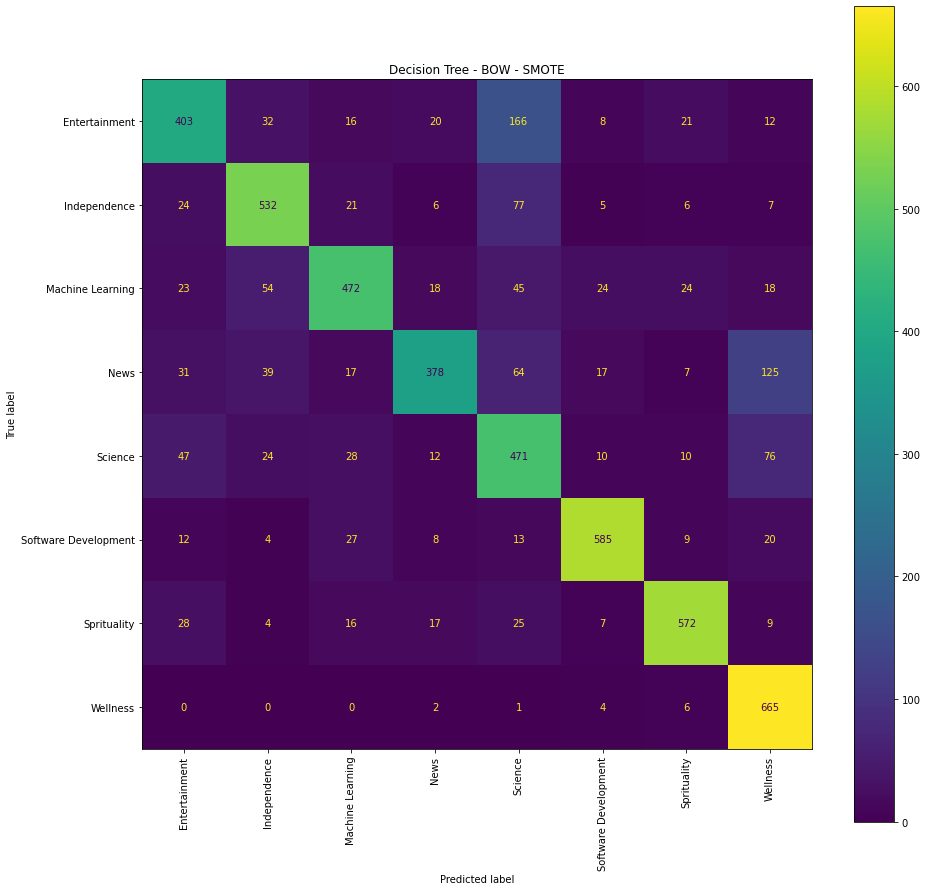

In [99]:
# y_pred = cross_val_predict(logistic_regression(), features, y_true, cv=10, n_jobs=6)

cm = confusion_matrix(target, y_pred)
print(cm)
f = ConfusionMatrixDisplay(
	cm,
	display_labels=topics
)
fig, ax = plt.subplots(figsize=(15, 15))
f.plot(ax=ax, xticks_rotation='vertical')
plt.title('Decision Tree - BOW - SMOTE')
plt.show()

------
# Resultados

| Representação Vetorial | Modelo | Score |
| --- | --- | --- |
| TFIDF (Sem smote) | Logistic Regression | 82.54 % |
| TFIDF (Sem smote) | Random Forest | 85.36 % |
| TFIDF (Sem smote) | Decision Tree | 79.88 % |
| 
| TFIDF (Com smote) | Logistic Regression | 89.76 % |
| TFIDF (Com smote) | Random Forest | 88.75 % |
| TFIDF (Com smote) | Decision Tree | 80.79 % |


| Representação Vetorial | Modelo | Score |
| --- | --- | --- |
| BOW (Sem smote) | Logistic Regression | 84.21 % |
| BOW (Sem smote) | Random Forest | 85.30 % |
| BOW (Sem smote) | Decision Tree | 80.32 % |
| |
| BOW (Com smote) | Logistic Regression | 80.80% |
| BOW (Com smote) | Random Forest | 79.47 % |
| BOW (Com smote) | Decision Tree | 75.18 % |

---
# Resultados rodando um tópico por vez

# Logistic Regression + TFIDF (Sem SMOTE)

## Geral
### 82.54 %

|                Topic      | precision   | recall | f1-score  | support |
|                ---      | ---   | --- | ---  | --- |
|        Entertainment      | 0.75     | 0.97     | 0.85     | 2028 |
|         Independence      | 0.92     | 0.62     | 0.74      | 392 |
|     Machine Learning      | 0.91     | 0.79     | 0.85      | 663 |
|                 News      | 0.79     | 0.81     | 0.80     | 1106 |
|              Science      | 0.96     | 0.34     | 0.50      | 318 |
| Software Development      | 0.98     | 0.88     | 0.93      | 580 |
|          Sprituality      | 0.96     | 0.77     | 0.85      | 678 |
|             Wellness      | 1.00     | 0.66     | 0.80      | 106 |


            accuracy                           0.83      5871 
           macro avg       0.91      0.73      0.79      5871 
        weighted avg       0.85      0.83      0.82      5871 

## Entertainment x Não Entertainment
### 89.79 %

| Topic | precision   | recall | f1-score  | support |
| --- | --- | ---  | --- |--- |
|     Entertainment      | 0.89     | 0.81     | 0.85     | 2028 |
| Não Entertainment      | 0.90     | 0.95     | 0.92     | 3843 |

         accuracy                            0.90      5871 
        macro avg        0.90      0.88      0.88      5871   
     weighted avg        0.90      0.90      0.90      5871 

## Independence x Não Independence
### 94.82 %

|  Topic                 | precision   | recall | f1-score  | support |
| ---                  | ---   | --- | -------  | --- |
|     Independence      | 0.93     | 0.24     | 0.38      | 392 |
| Não Independence      | 0.95     | 1.00     | 0.97     | 5479 |

        accuracy                           0.95      5871 
       macro avg       0.94      0.62      0.68      5871 
    weighted avg       0.95      0.95      0.93      5871 

## Machine Learning x Não Machine Learning
### 94.78 %

| Topic | precision   | recall | f1-score  | support |
|  ---                     | ---   | --- | -------  | --- |
|     Machine Learning      | 0.99     | 0.55     | 0.70      | 663 |
| Não Machine Learning      | 0.95     | 1.00     | 0.97     | 5208 |

             accuracy                           0.95      5871 
            macro avg       0.97      0.77      0.84      5871 
         weighted avg       0.95      0.95      0.94      5871 

## News x Não News
### 88.82 %

| Topic             | precision   | recall | f1-score  | support |
| ---             | ---   | --- | -------  | --- |
|         News      | 1.00     | 0.41     | 0.58     | 1106 |
|     Não News      | 0.88     | 1.00     | 0.94     | 4765 |

           accuracy                           0.89      5871
          macro avg       0.94      0.70      0.76      5871
       weighted avg       0.90      0.89      0.87      5871

## Science x Não Science
### 95.00 %

| Topic             | precision   | recall | f1-score  | support |
| ---             | ---   | --- | -------  | --- |
|      Science      | 0.95     | 1.00     | 0.97     | 5553 |
|  Não Science      | 1.00     | 0.08     | 0.15      | 318 |

            accuracy                           0.95      5871
           macro avg       0.97      0.54      0.56      5871
        weighted avg       0.95      0.95      0.93      5871

## Software Development x Não Software Development
### 95.67 %

| Topic                         | precision   | recall | f1-score  | support |
| ---                         | ---   | --- | -------  | --- |
|     Software Development      | 0.95     | 1.00     | 0.98     | 5291 |
| Não Software Development      | 1.00     | 0.56     | 0.72      | 580 |

                accuracy                           0.96      5871
               macro avg       0.98      0.78      0.85      5871
            weighted avg       0.96      0.96      0.95      5871

## Sprituality x Não Sprituality
### 94.07 %

| Topic                | precision   | recall | f1-score  | support |
| ---                | ---   | --- | -------  | --- |
|     Sprituality      | 0.94     | 1.00     | 0.97     | 5193 |
| Não Sprituality      | 0.99     | 0.49     | 0.66      | 678 |

          accuracy                           0.94      5871
         macro avg       0.96      0.75      0.81      5871
      weighted avg       0.94      0.94      0.93      5871

## Wellness x Não Wellness
### 98.79 %

| Topic             | precision   | recall | f1-score  | support |
| ---             | ---   | --- | -------  | --- |
|     Wellness      | 0.99     | 1.00     | 0.99     | 5765 |
| Não Wellness      | 1.00     | 0.33     | 0.50      | 106 |

            accuracy                           0.99      5871
           macro avg       0.99      0.67      0.75      5871
        weighted avg       0.99      0.99      0.98      5871

---
# Random Forest + TFIDF (Sem SMOTE)

## Geral
### 85.57 %

| Topic                     | precision   | recall | f1-score  | support |
| ---                     | ---   | --- | -------  | --- |
|        Entertainment      | 0.79     | 0.95     | 0.86     | 2028 |
|         Independence      | 0.87     | 0.72     | 0.79      | 392 |
|     Machine Learning      | 0.90     | 0.80     | 0.85      | 663 |
|                 News      | 0.85     | 0.84     | 0.85     | 1106 |
|              Science      | 0.91     | 0.39     | 0.55      | 318 |
| Software Development      | 0.95     | 0.94     | 0.94      | 580 |
|          Sprituality      | 0.94     | 0.87     | 0.90      | 678 |
|             Wellness      | 1.00     | 0.74     | 0.85      | 106 |

            accuracy                           0.85      5871
           macro avg       0.90      0.78      0.82      5871
        weighted avg       0.86      0.85      0.85      5871

--- 
# Decision Tree + TFIDF (Sem SMOTE)

## Geral
### 79.88 % 

| Topic                 | precision   | recall | f1-score  | support |
| ---                 | ---   | --- | -------  | --- |
|        Entertainment      | 0.83     | 0.89     | 0.86     | 2028 |
|         Independence      | 0.71     | 0.71     | 0.71      | 392 |
|     Machine Learning      | 0.74     | 0.69     | 0.71      | 663 |
|                 News      | 0.81     | 0.82     | 0.82     | 1106 |
|              Science      | 0.50     | 0.38     | 0.43      | 318 |
| Software Development      | 0.86     | 0.83     | 0.85      | 580 |
|          Sprituality      | 0.84     | 0.82     | 0.83      | 678 |
|             Wellness      | 0.80     | 0.70     | 0.74      | 106 |

            accuracy                           0.80      5871
           macro avg       0.76      0.73      0.74      5871
        weighted avg       0.79      0.80      0.79      5871

## Geral (Profundidade 5)

### 58.21 %

| Topic | precision   | recall | f1-score  | support|
| ---                      | ---   | --- | -------  | ---|
|        Entertainment      | 0.70     | 0.85     | 0.77     | 2028|
|         Independence      | 0.85     | 0.14     | 0.24      | 392|
|     Machine Learning      | 0.65     | 0.42     | 0.51      | 663|
|                 News      | 0.35     | 0.76     | 0.48     | 1106|
|              Science      | 0.60     | 0.01     | 0.02      | 318|
| Software Development      | 0.97     | 0.46     | 0.62      | 580|
|          Sprituality      | 0.99     | 0.35     | 0.52      | 678|
|             Wellness      | 1.00     | 0.15     | 0.26      | 106|

            accuracy                           0.58      5871
           macro avg       0.76      0.39      0.43      5871
        weighted avg       0.70      0.58      0.56      5871

---
## Logistic Regression + BOW (Sem SMOTE)
### 84.21 %

| Topic    | precision   | recall | f1-score  | support|
| ---    | ---   | --- | -------  | ---|
|        Entertainment      | 0.80     | 0.93     | 0.86     | 2028|
|         Independence      | 0.81     | 0.71     | 0.76      | 392|
|     Machine Learning      | 0.89     | 0.81     | 0.85      | 663|
|                 News      | 0.82     | 0.84     | 0.83     | 1106|
|              Science      | 0.75     | 0.47     | 0.58      | 318|
| Software Development      | 0.95     | 0.91     | 0.93      | 580|
|          Sprituality      | 0.93     | 0.82     | 0.87      | 678|
|             Wellness      | 0.98     | 0.75     | 0.85      | 106|

            accuracy                           0.84      5871
           macro avg       0.87      0.78      0.82      5871
        weighted avg       0.84      0.84      0.84      5871

---

## Random Forest + BOW (Sem SMOTE)
### 85.30 %

| Topic     | precision   | recall | f1-score  | support|
| ---     | ---   | --- | -------  | ---|
|        Entertainment      | 0.82     | 0.88     | 0.85     | 2028|
|         Independence      | 0.74     | 0.72     | 0.73      | 392|
|     Machine Learning      | 0.78     | 0.71     | 0.74      | 663|
|                 News      | 0.81     | 0.82     | 0.81     | 1106|
|              Science      | 0.55     | 0.47     | 0.51      | 318|
| Software Development      | 0.88     | 0.83     | 0.85      | 580|
|          Sprituality      | 0.88     | 0.84     | 0.86      | 678|
|             Wellness      | 0.76     | 0.73     | 0.74      | 106|

            accuracy                           0.80      5871
           macro avg       0.78      0.75      0.76      5871
        weighted avg       0.80      0.80      0.80      5871

---

## Decision Tree + BOW (Sem SMOTE)
### 80.25 %

| Topic                      | precision   | recall | f1-score  | support|
| ---                      | ---   | --- | -------  | ---|
|        Entertainment      | 0.82     | 0.88     | 0.85     | 2028|
|         Independence      | 0.73     | 0.72     | 0.73      | 392|
|     Machine Learning      | 0.78     | 0.73     | 0.75      | 663|
|                 News      | 0.80     | 0.81     | 0.81     | 1106|
|              Science      | 0.52     | 0.43     | 0.47      | 318|
| Software Development      | 0.88     | 0.84     | 0.86      | 580|
|          Sprituality      | 0.87     | 0.84     | 0.85      | 678|
|             Wellness      | 0.77     | 0.71     | 0.74      | 106|

            accuracy                           0.80      5871
           macro avg       0.77      0.75      0.76      5871
        weighted avg       0.80      0.80      0.80      5871

---
# Logistic Regression + TFIDF (Com SMOTE)

## Geral
### 89.76 %

| Topic                     | precision   | recall | f1-score  | support|
| ---                     | ---   | --- | -------  | --- |
|        Entertainment      | 0.74     | 0.87     | 0.80      | 678|
|         Independence      | 0.92     | 0.94     | 0.93      | 678|
|     Machine Learning      | 0.94     | 0.82     | 0.88      | 678|
|                 News      | 0.81     | 0.83     | 0.82      | 678|
|              Science      | 0.91     | 0.92     | 0.92      | 678|
| Software Development      | 0.97     | 0.94     | 0.96      | 678|
|          Sprituality      | 0.94     | 0.86     | 0.90      | 678|
|             Wellness      | 1.00     | 0.99     | 1.00      | 678|

            accuracy                           0.90      5424
           macro avg       0.90      0.90      0.90      5424
        weighted avg       0.90      0.90      0.90      5424

---
# Random Forest + TFIDF (Com SMOTE)

## Geral
### 88.75 %

| Topic                    | precision   | recall | f1-score  | support|
| ---                    | ---   | --- | -------  | --- |
|        Entertainment      | 0.68     | 0.90     | 0.77      | 678|
|         Independence      | 0.90     | 0.92     | 0.91      | 678|
|     Machine Learning      | 0.93     | 0.81     | 0.87      | 678|
|                 News      | 0.83     | 0.81     | 0.82      | 678|
|              Science      | 0.95     | 0.85     | 0.90      | 678|
| Software Development      | 0.97     | 0.95     | 0.96      | 678|
|          Sprituality      | 0.94     | 0.88     | 0.91      | 678|
|             Wellness      | 1.00     | 0.99     | 0.99      | 678|

            accuracy                           0.89      5424
           macro avg       0.90      0.89      0.89      5424
        weighted avg       0.90      0.89      0.89      5424

---
# Decision Tree + TFIDF (Com SMOTE)

## Geral
### 80.79 %

| Topic                   | precision   | recall | f1-score  | support |
| ---                   | ---   | --- | -------  | ---|
|        Entertainment      | 0.68     | 0.78     | 0.73      | 678|
|         Independence      | 0.85     | 0.83     | 0.84      | 678|
|     Machine Learning      | 0.75     | 0.70     | 0.72      | 678|
|                 News      | 0.76     | 0.77     | 0.77      | 678|
|              Science      | 0.75     | 0.73     | 0.74      | 678|
| Software Development      | 0.90     | 0.86     | 0.88      | 678|
|          Sprituality      | 0.83     | 0.82     | 0.83      | 678|
|             Wellness      | 0.96     | 0.97     | 0.96      | 678|

            accuracy                           0.81      5424
           macro avg       0.81      0.81      0.81      5424
        weighted avg       0.81      0.81      0.81      5424


# Logistic Regression + BOW (Com SMOTE)

## Geral
### 80.80 %

| Topic                  | precision   | recall | f1-score  | support|
| ---                  | ---   | --- | -------  | ---|
|        Entertainment      | 0.61     | 0.82     | 0.70      | 678|
|         Independence      | 0.83     | 0.82     | 0.83      | 678|
|     Machine Learning      | 0.91     | 0.79     | 0.84      | 678|
|                 News      | 0.84     | 0.66     | 0.74      | 678|
|              Science      | 0.75     | 0.65     | 0.70      | 678|
| Software Development      | 0.94     | 0.90     | 0.92      | 678|
|          Sprituality      | 0.92     | 0.83     | 0.88      | 678|
|             Wellness      | 0.76     | 0.99     | 0.86      | 678|

            accuracy                           0.81      5424
           macro avg       0.82      0.81      0.81      5424
        weighted avg       0.82      0.81      0.81      5424


# Random Forest + BOW (Com SMOTE)

## Geral
### 79.47 %

| Topic                  | precision   | recall | f1-score  | support|
| ---                  | ---   | --- | -------  | ---|
|        Entertainment      | 0.71     | 0.65     | 0.68      | 678|
|         Independence      | 0.76     | 0.84     | 0.80      | 678|
|     Machine Learning      | 0.92     | 0.77     | 0.84      | 678|
|                 News      | 0.93     | 0.55     | 0.69      | 678|
|              Science      | 0.61     | 0.77     | 0.68      | 678|
| Software Development      | 0.94     | 0.91     | 0.93      | 678|
|          Sprituality      | 0.97     | 0.88     | 0.92      | 678|
|             Wellness      | 0.71     | 1.00     | 0.83      | 678|

            accuracy                           0.80      5424
           macro avg       0.82      0.80      0.79      5424
        weighted avg       0.82      0.80      0.79      5424

# Decision Tree + BOW (Com SMOTE)

## Geral
### 75.18 %

| Topic                  | precision   | recall | f1-score  | support|
| ---                  | ---   | --- | -------  | --- |
|        Entertainment      | 0.71     | 0.59     | 0.65      | 678|
|         Independence      | 0.77     | 0.78     | 0.78      | 678|
|     Machine Learning      | 0.79     | 0.70     | 0.74      | 678|
|                 News      | 0.82     | 0.56     | 0.66      | 678|
|              Science      | 0.55     | 0.69     | 0.61      | 678|
| Software Development      | 0.89     | 0.86     | 0.87      | 678|
|          Sprituality      | 0.87     | 0.84     | 0.86      | 678|
|             Wellness      | 0.71     | 0.98     | 0.83      | 678|

            accuracy                           0.75      5424
           macro avg       0.76      0.75      0.75      5424
        weighted avg       0.76      0.75      0.75      5424